In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from toolz import partial, valmap
from tqdm.auto import tqdm
from aging.plotting import figure, format_plots, add_identity, legend
from aging.behavior.bio_age_model import (
    age_normalizer_factory,
    neg_log_likelihood,
    optimize,
    model_fun_v0,
    get_biological_age,
    initialize_params,
    create_masks,
    masked_xval,
    fit_model
)
from itertools import product
from sklearn.preprocessing import OneHotEncoder
from aging.behavior.bio_age_model import raise_dim
from toolz import pluck
from sklearn.metrics import r2_score

In [2]:
warnings.simplefilter("ignore")
format_plots()

In [3]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()

In [4]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet"
)
df = df.sort_index(axis=1)

n_syllables = 55
age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))[:, :n_syllables]

34


<Axes: >

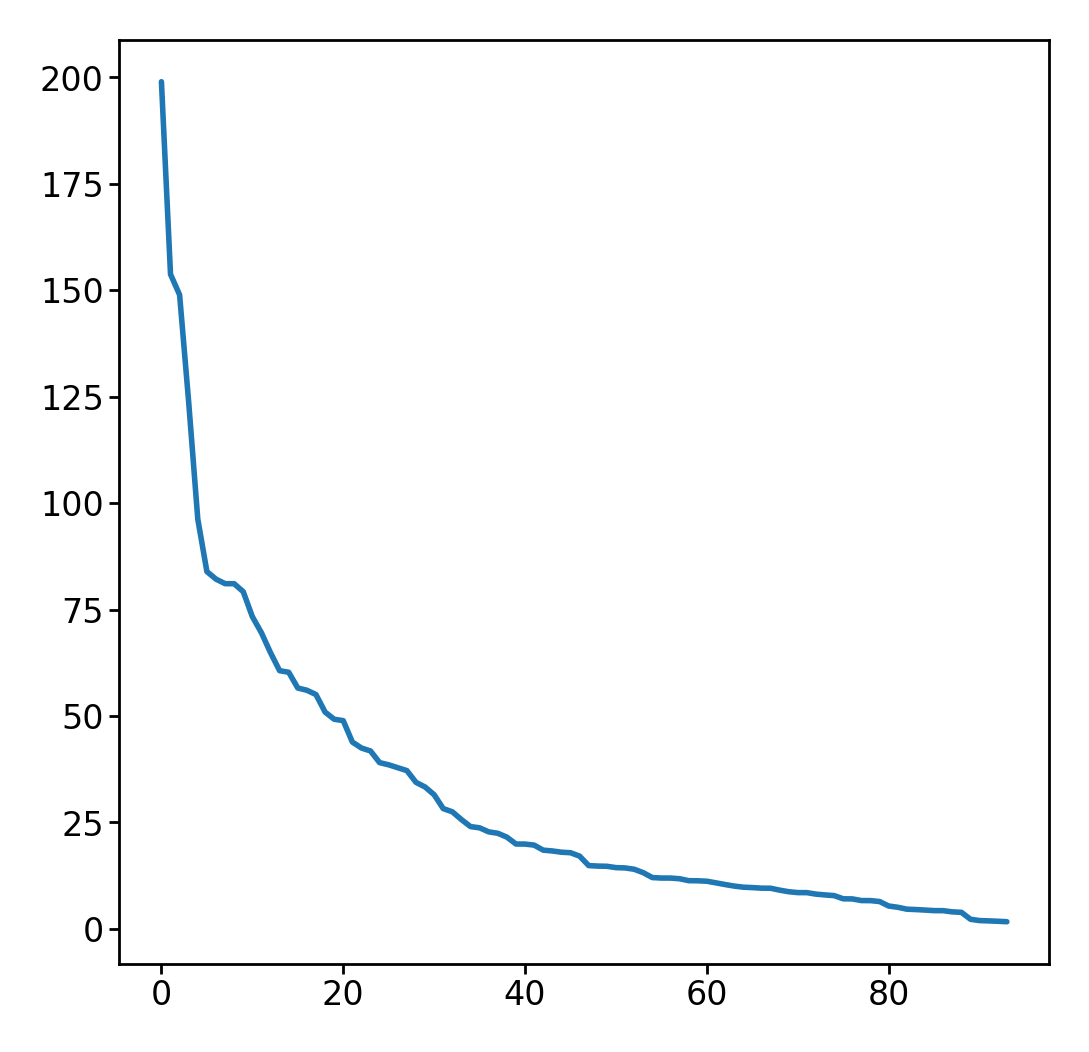

In [6]:
print((df.mean() > 25).sum())
df.mean().plot()

In [10]:
features = {
    "ages": age,
    "counts": syllable_counts_jax + 1,
}

hypparams = {
    "min_age": 1,
    "max_age": 130,
    "age_sd": 26,  # weeks
    "bio_params_sd": 10,
    "n_age_samples": 500,
    "n_splines": None,
    "n_syllables": n_syllables,
    "n_keep_sylls": 40,
    "n_sessions": len(syllable_counts_jax),
    "lr": 0.2,
    "n_opt_iter": 150,
}


# output = fit_model(features, hypparams, model_version=0)
output = masked_xval(features, hypparams, model_version=0, n_repeats=1)

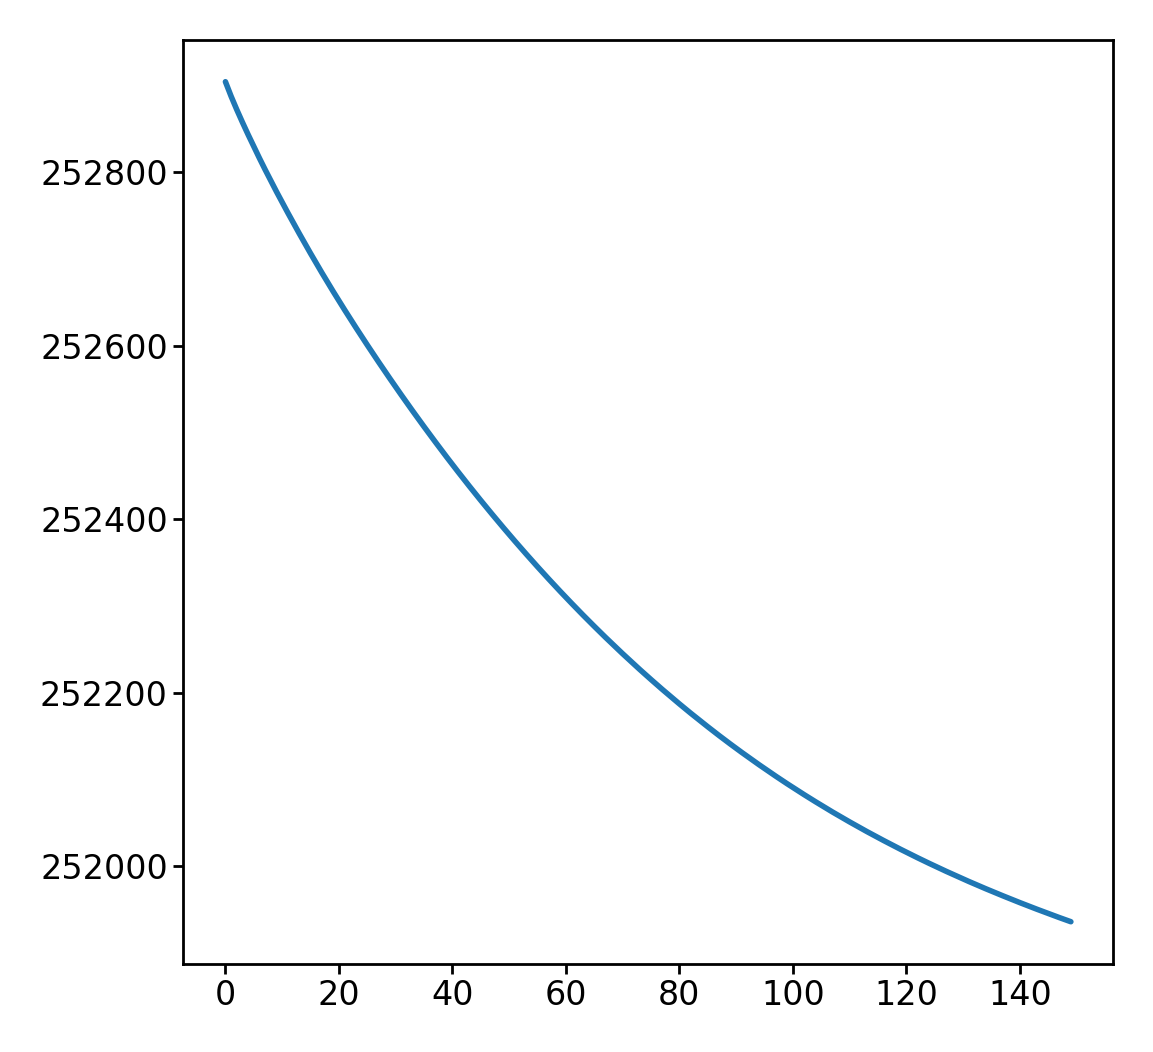

In [11]:
plt.plot(output[0]['loss'])

In [12]:
age_samples = output[0]['init_components'].age_samples
pred_counts = output[0]['params']["bio_basis_weights"] @ jnp.stack(
    [age_samples, jnp.ones_like(age_samples)]
)

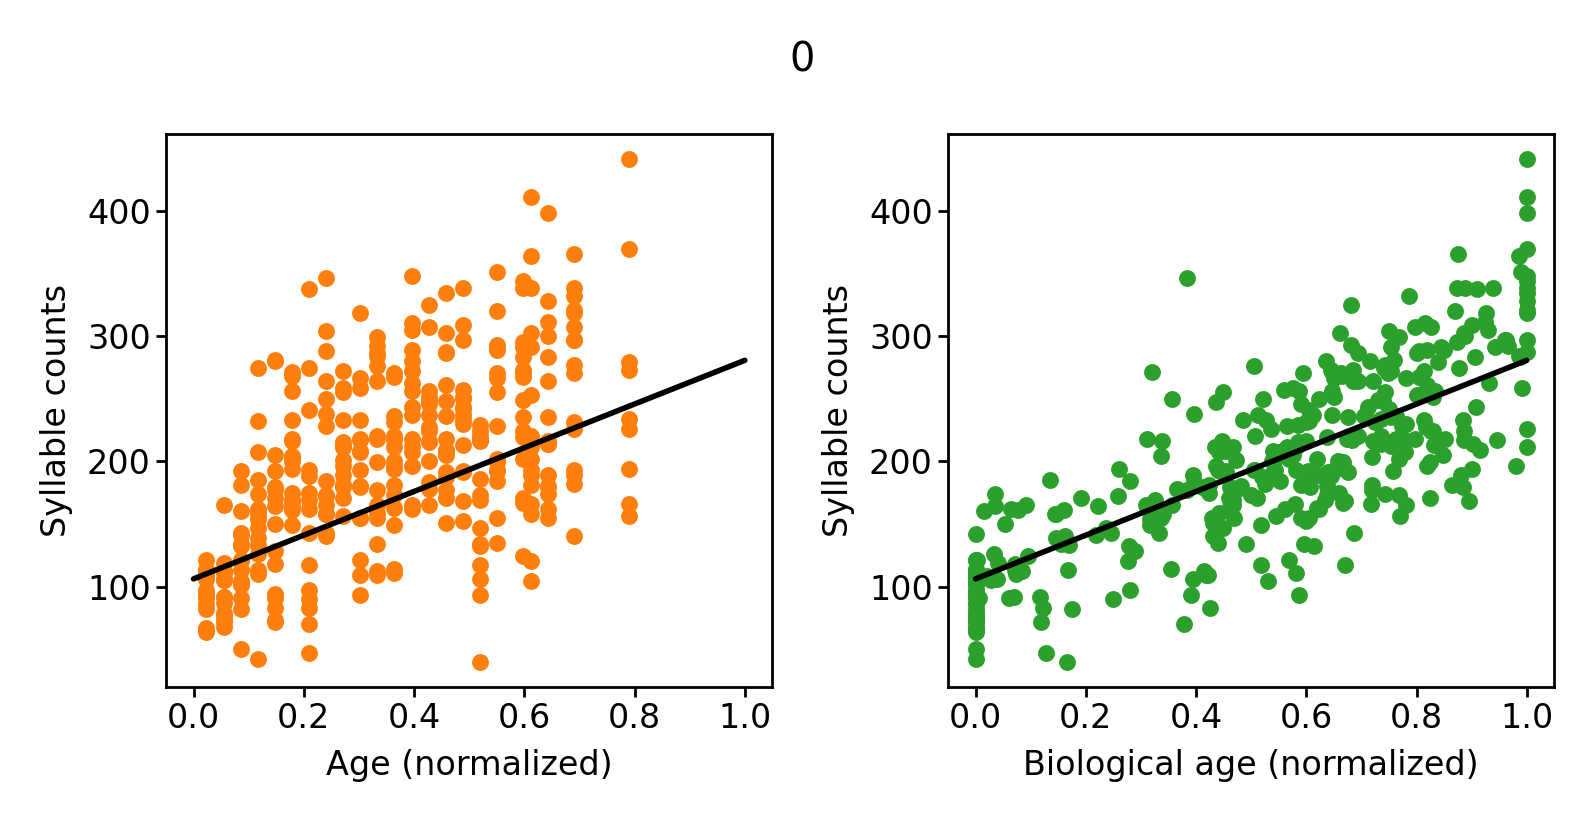

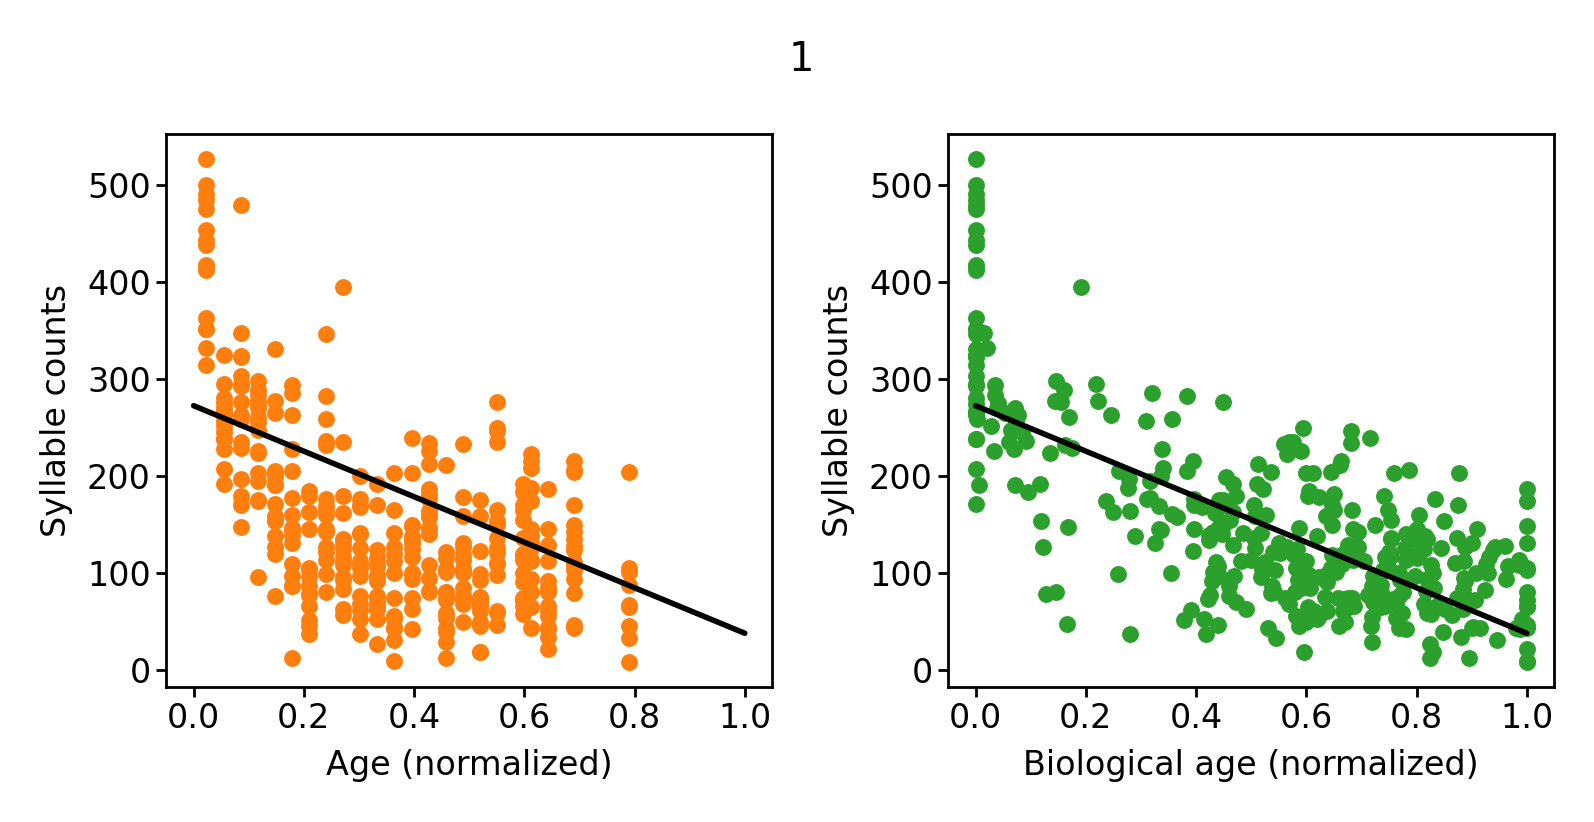

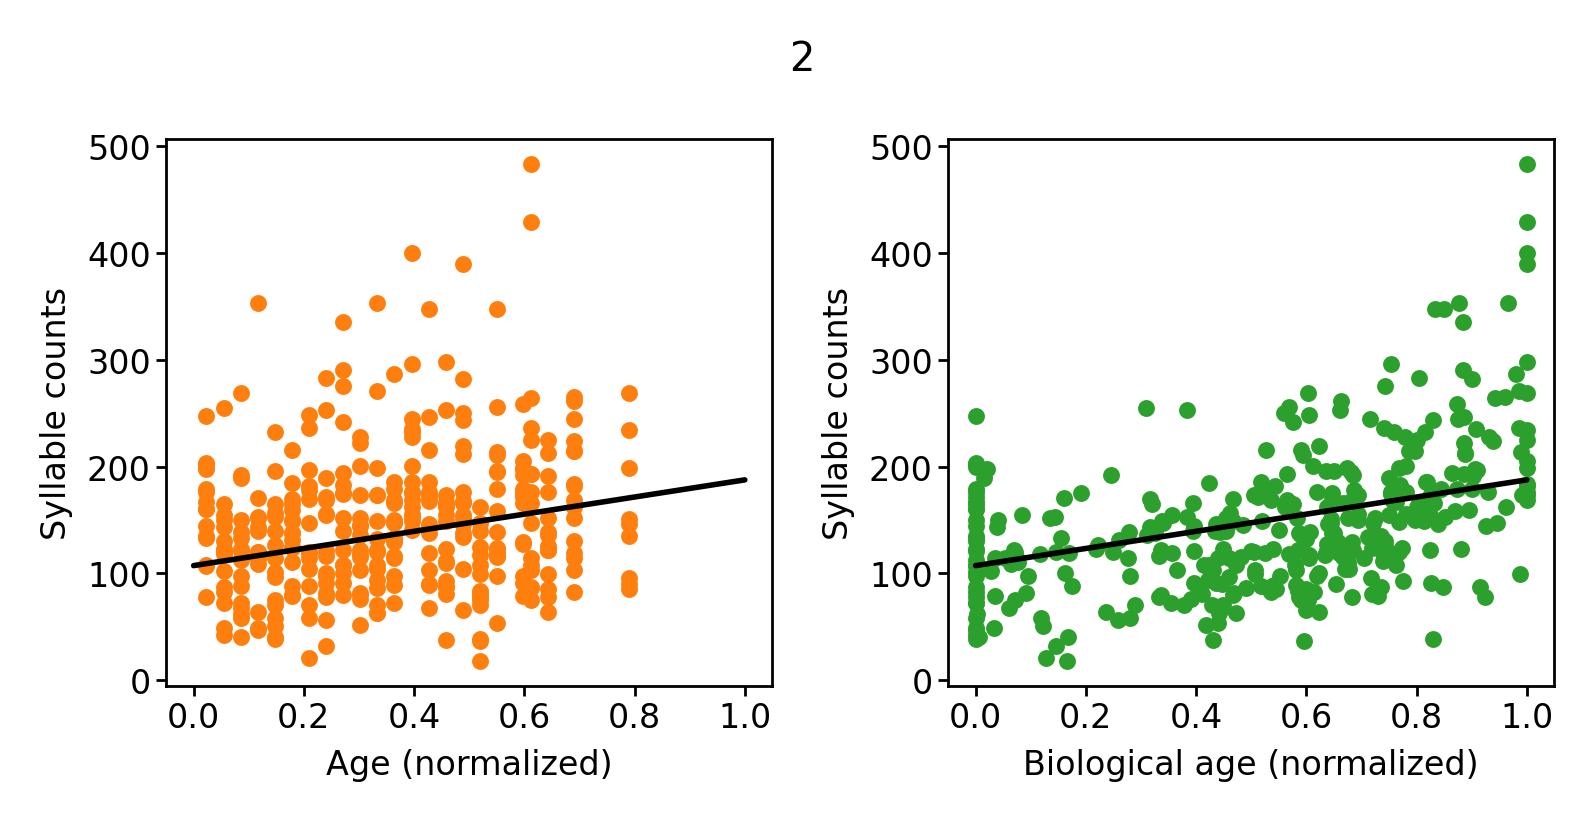

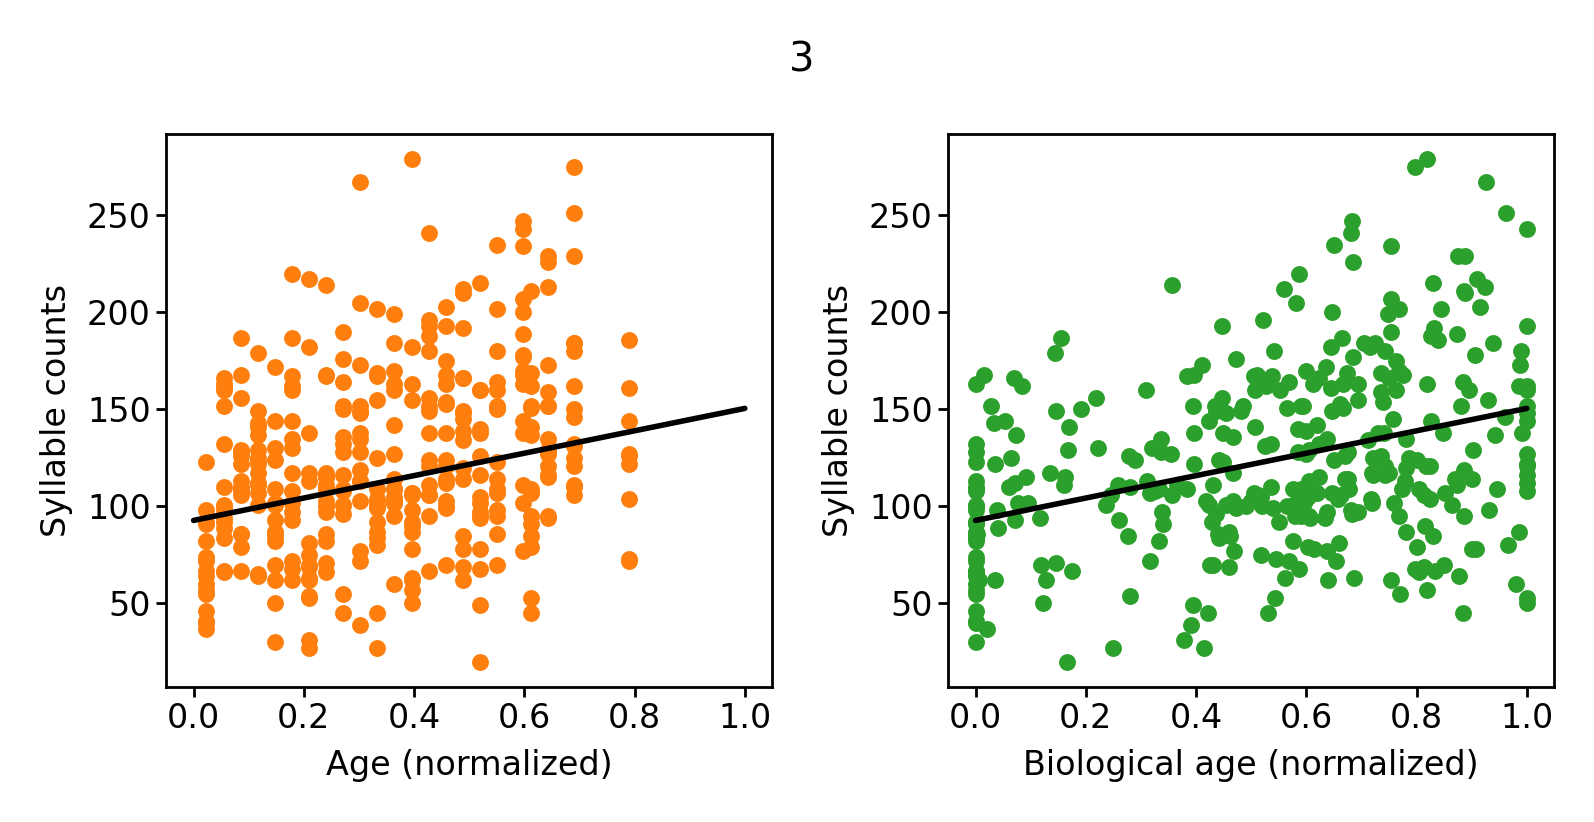

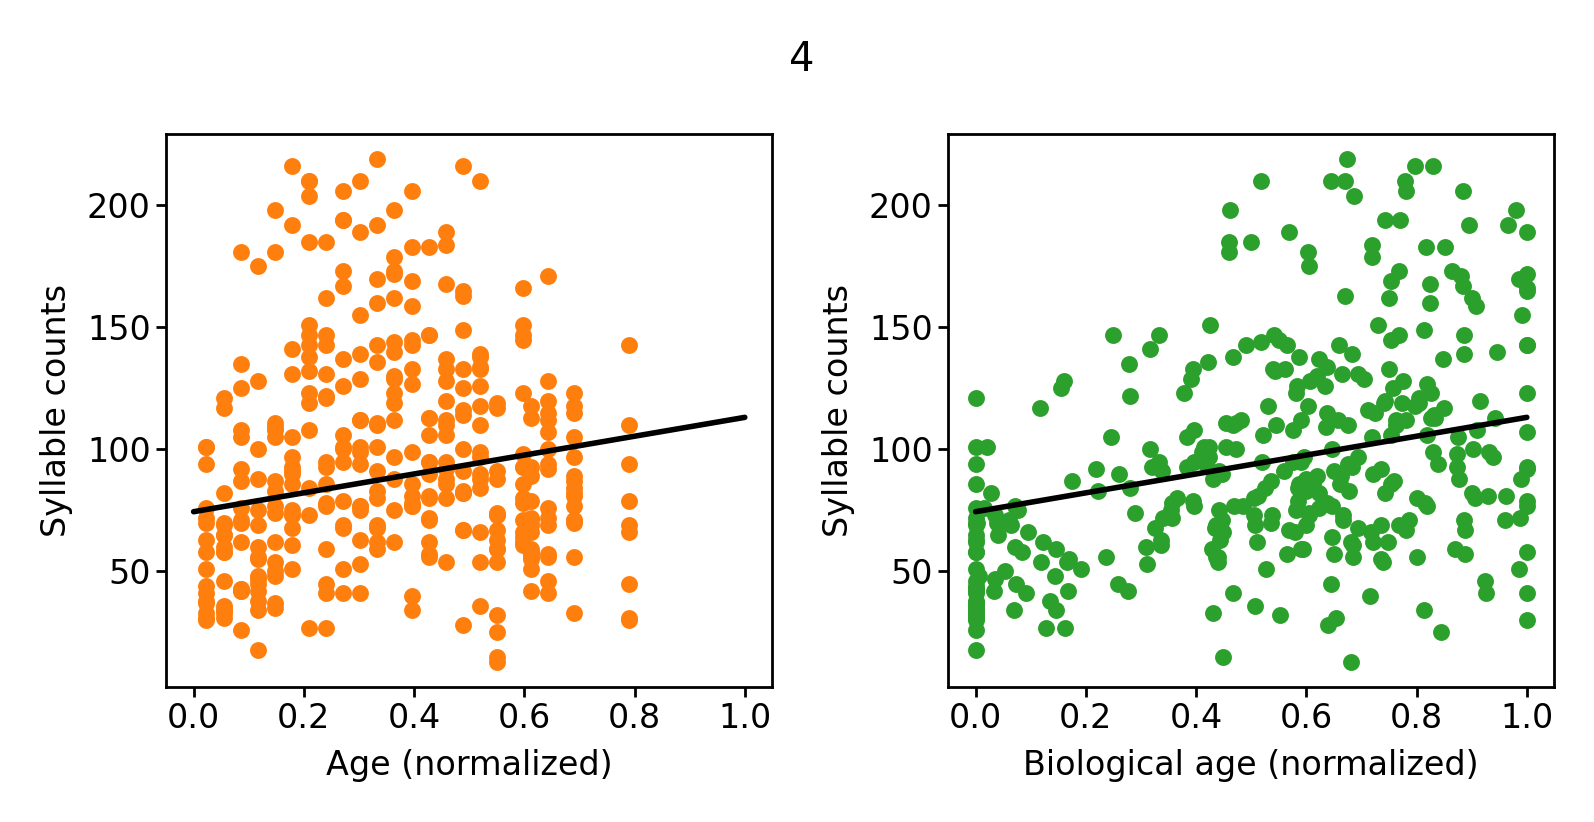

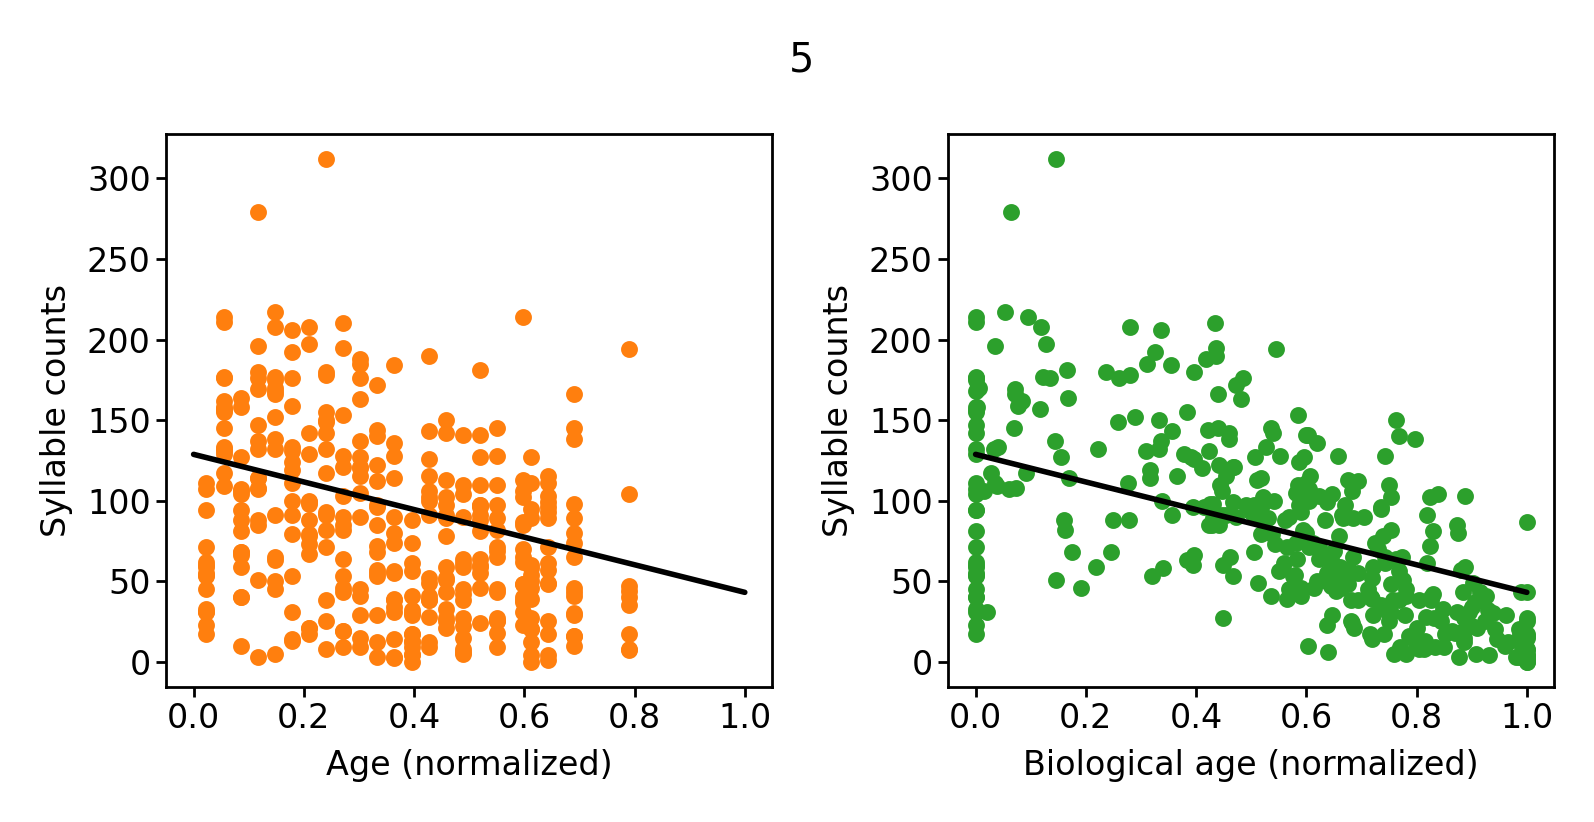

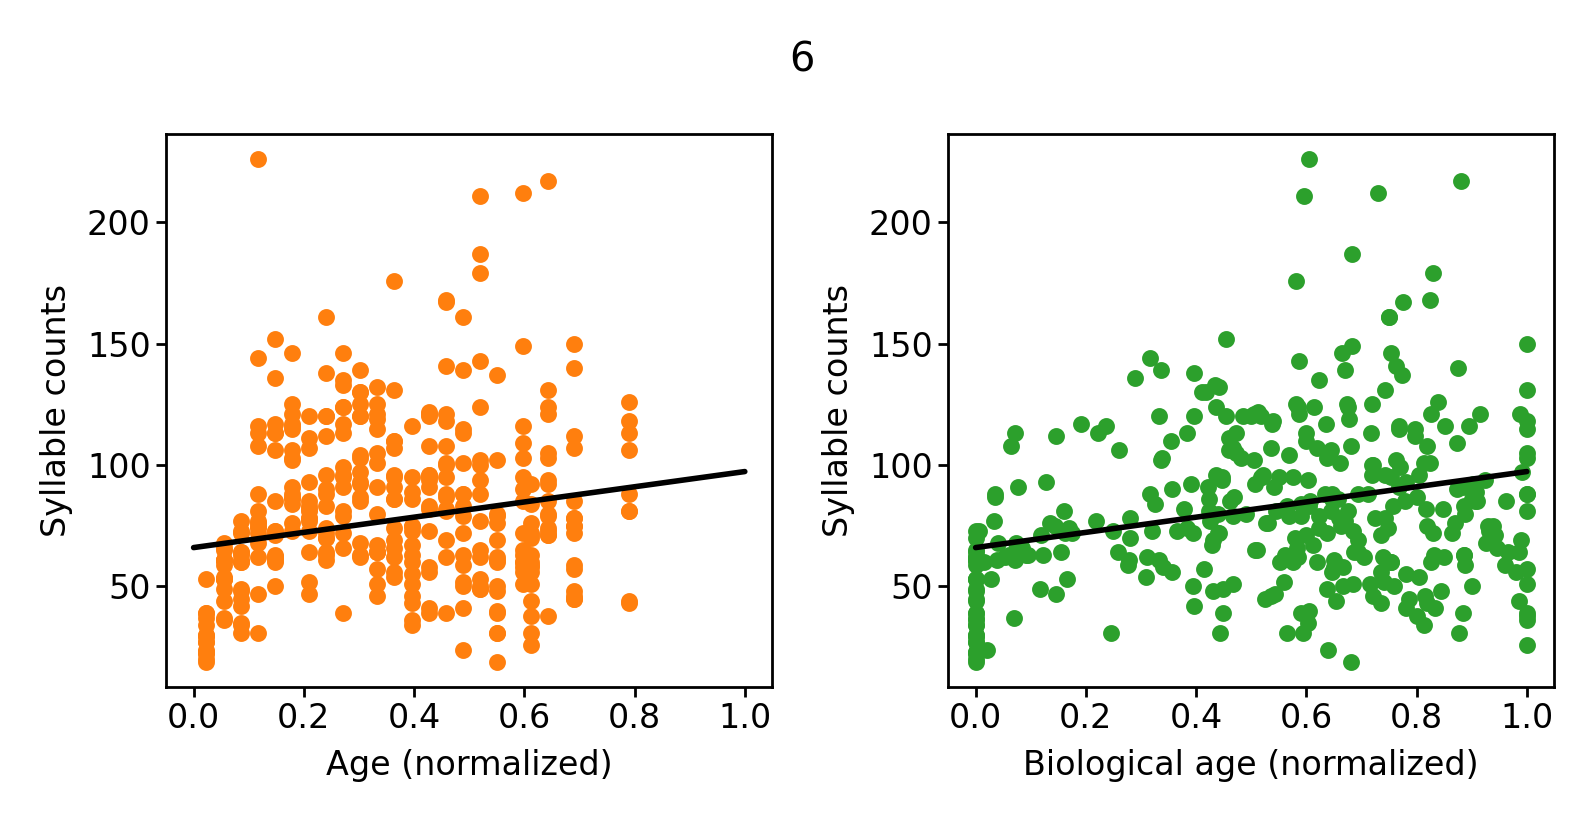

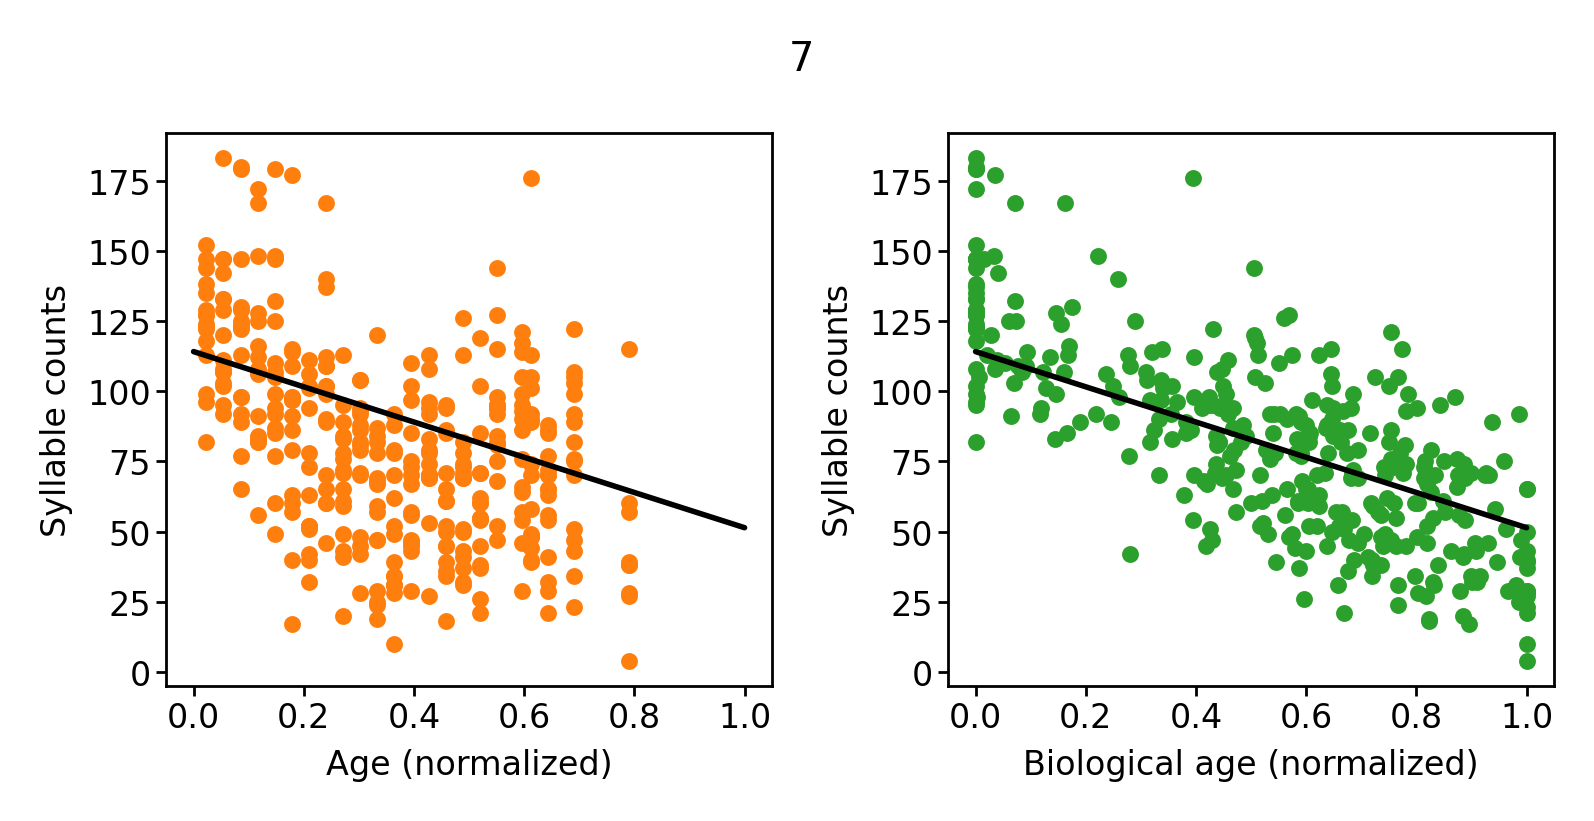

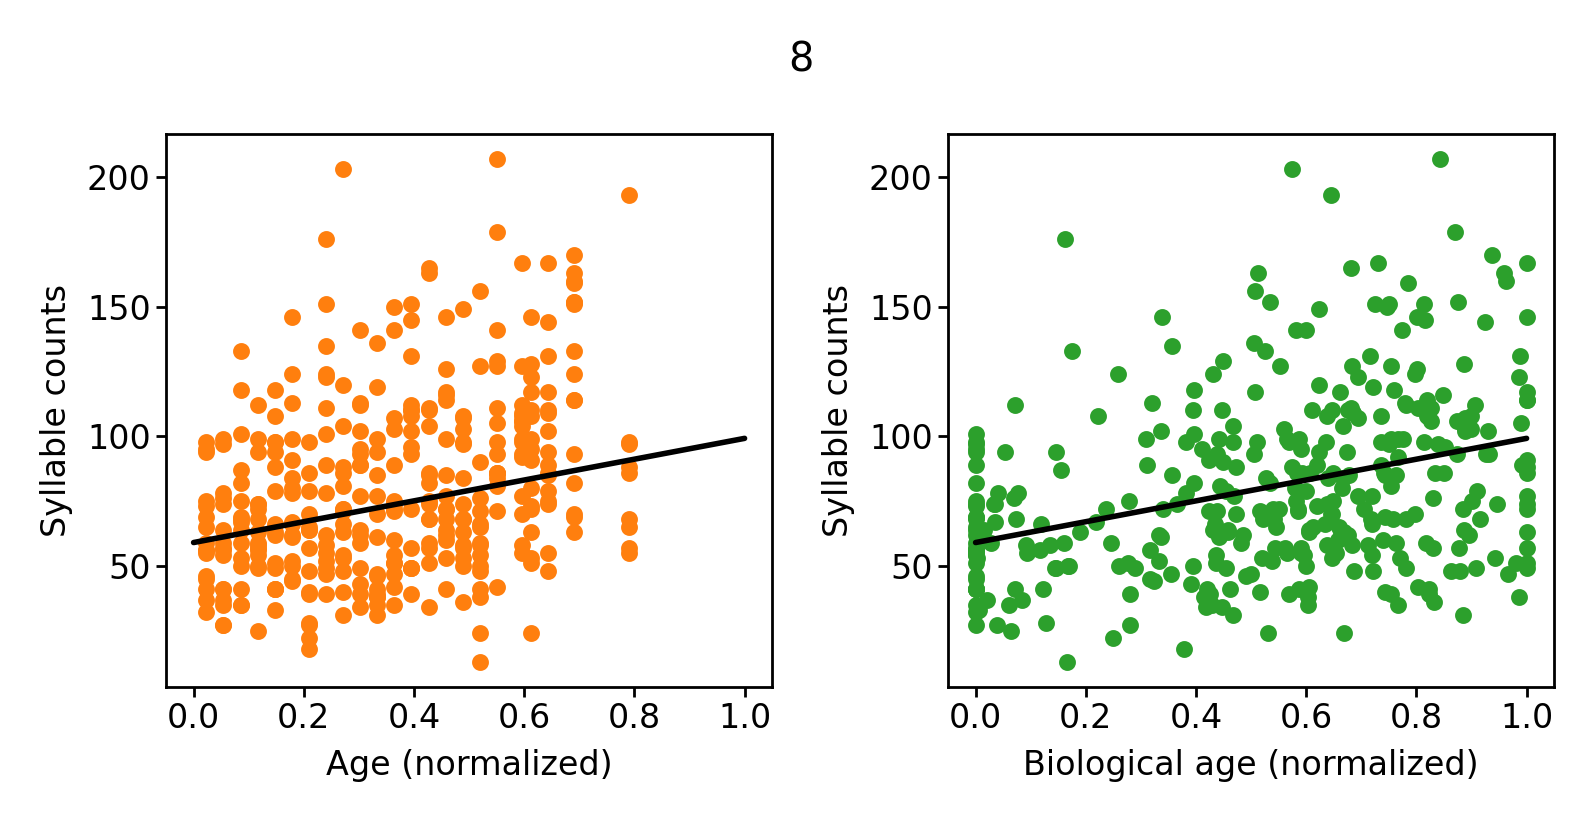

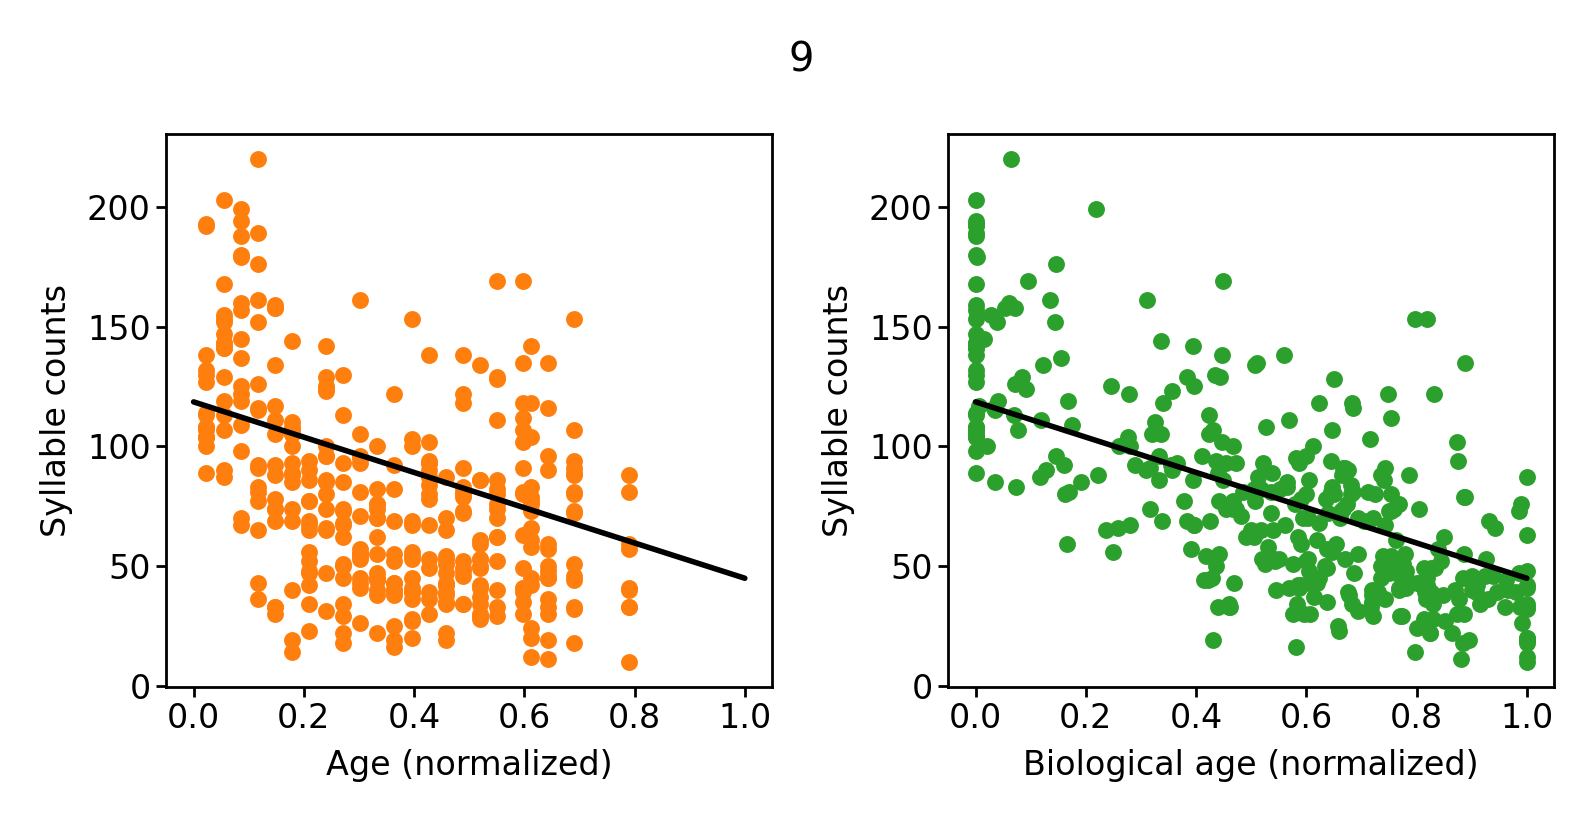

In [13]:
age_normalizer = output[0]['init_components'].age_normalizer
age_samples = output[0]['init_components'].age_samples
for syll in range(10):
    fig, ax = plt.subplots(1, 2, figsize=(4, 2))
    ax[0].plot(age_samples, pred_counts[syll], color='k')
    ax[0].scatter(age_normalizer(age), syllable_counts_jax[:, syll], c='C1', s=5)
    ax[0].set(xlabel="Age (normalized)", ylabel="Syllable counts")
    ax[1].plot(age_samples, pred_counts[syll], color='k')
    ax[1].scatter(age_normalizer(output[0]['bio_ages']), syllable_counts_jax[:, syll], c='C2', s=5)
    ax[1].set(xlabel="Biological age (normalized)", ylabel="Syllable counts")
    fig.suptitle(syll)
    fig.tight_layout()

In [14]:
output[0]['heldout_r2_total']

0.4391385826439249

In [10]:
output['heldout_ll']

-517064

In [11]:
def predicted_counts(bio_age, values):
    return jnp.interp(bio_age, jnp.linspace(0, 1, 500), values)
predicted_counts = jax.vmap(predicted_counts, in_axes=(None, 1))

<Axes: xlabel='True age', ylabel='Biological age'>

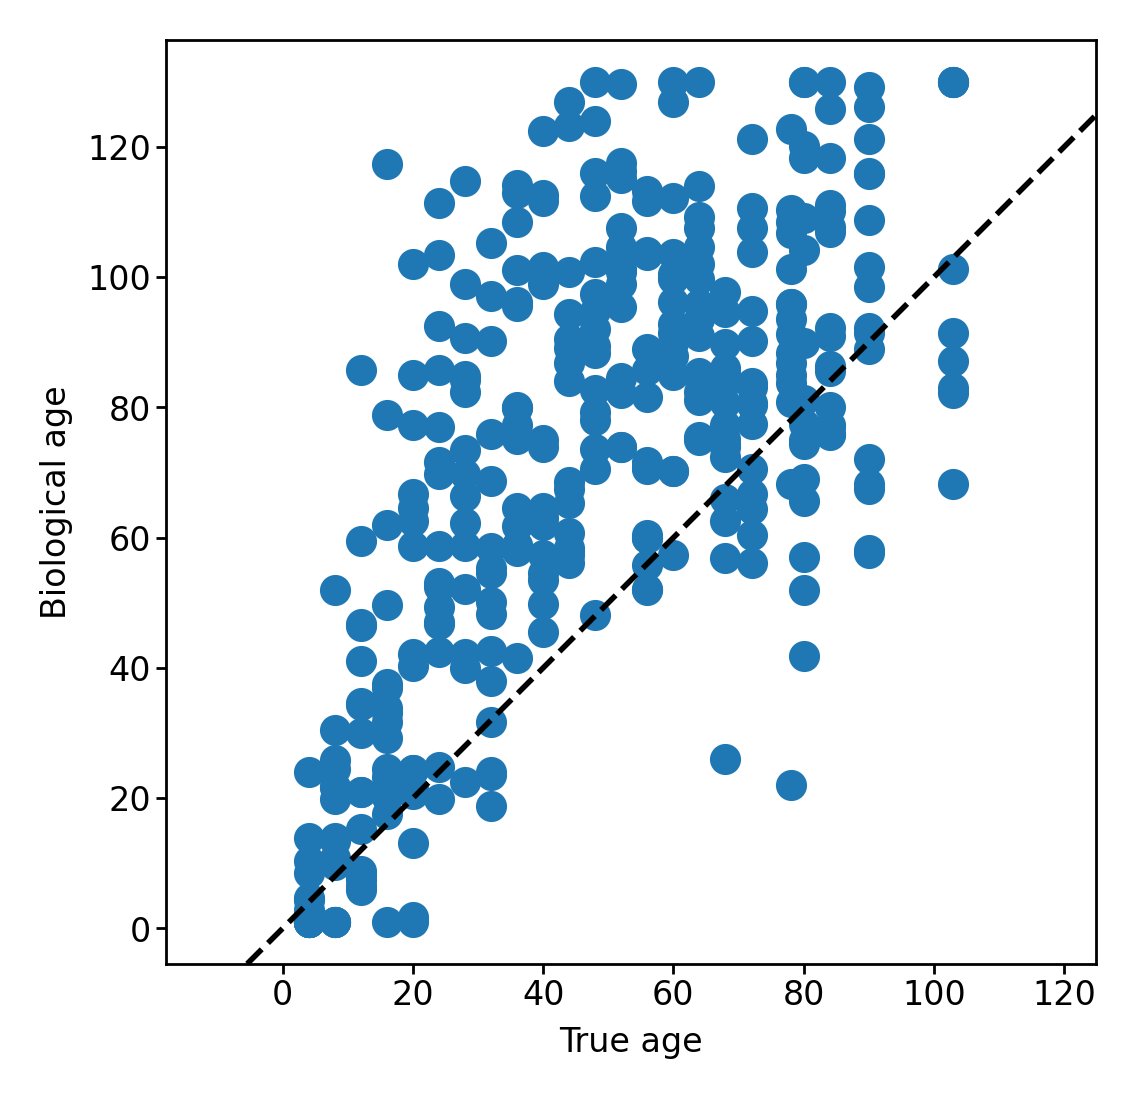

In [19]:
plt.scatter(age, output['bio_ages'])
plt.xlabel("True age")
plt.ylabel("Biological age")
plt.axis('equal')
add_identity(plt.gca(), ls='--', color='k')

In [13]:
out = predicted_counts(age_normalizer(output['bio_ages']), pred_counts.T).T

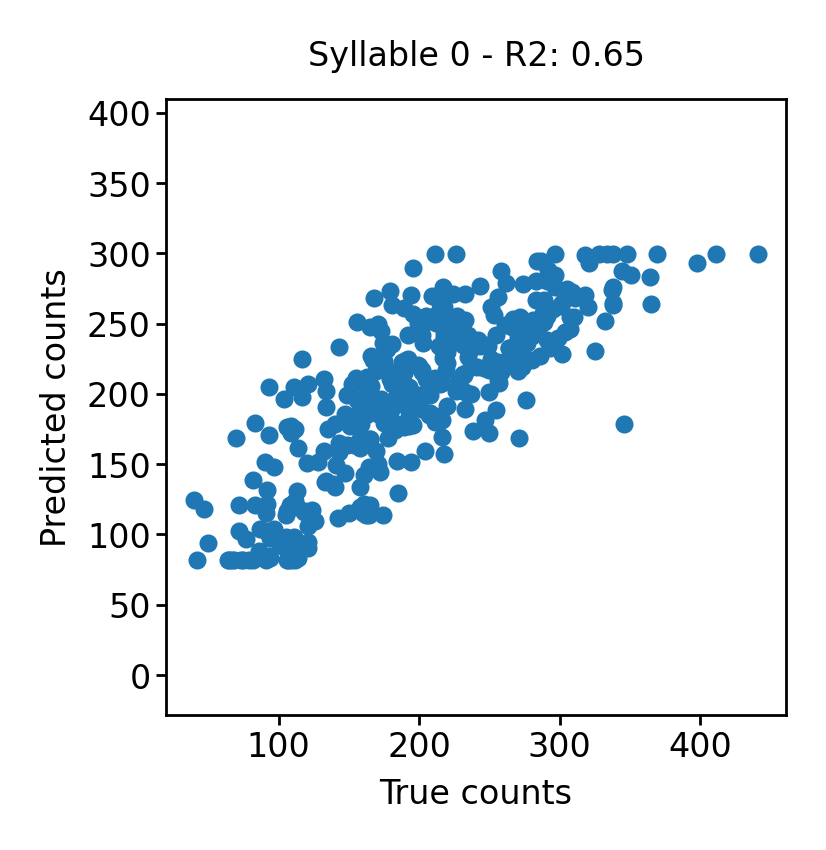

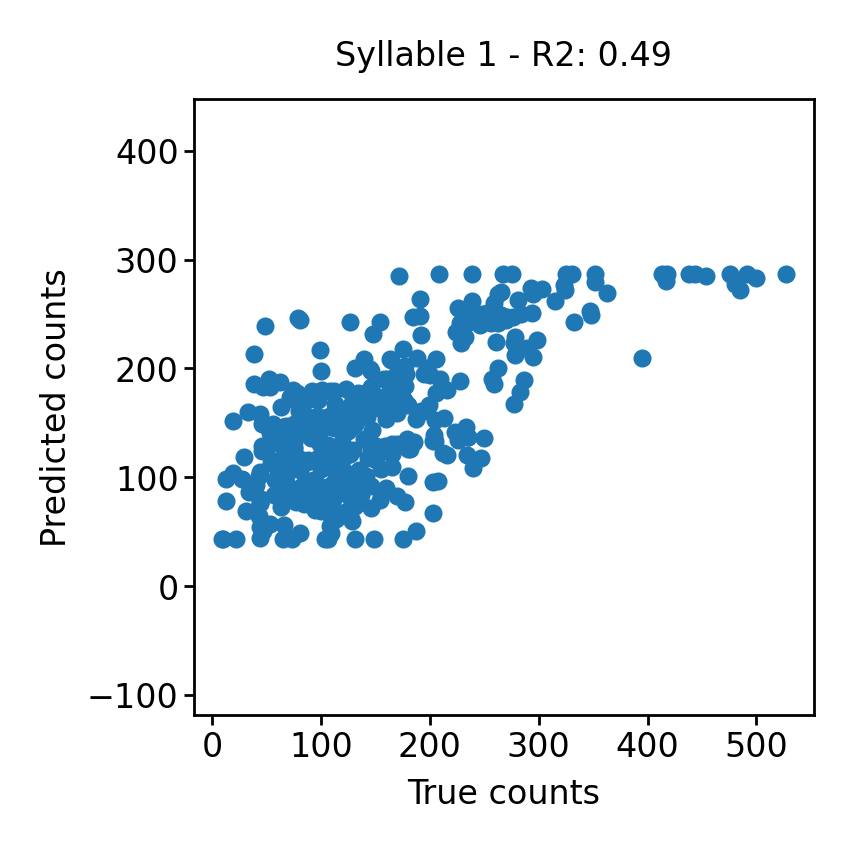

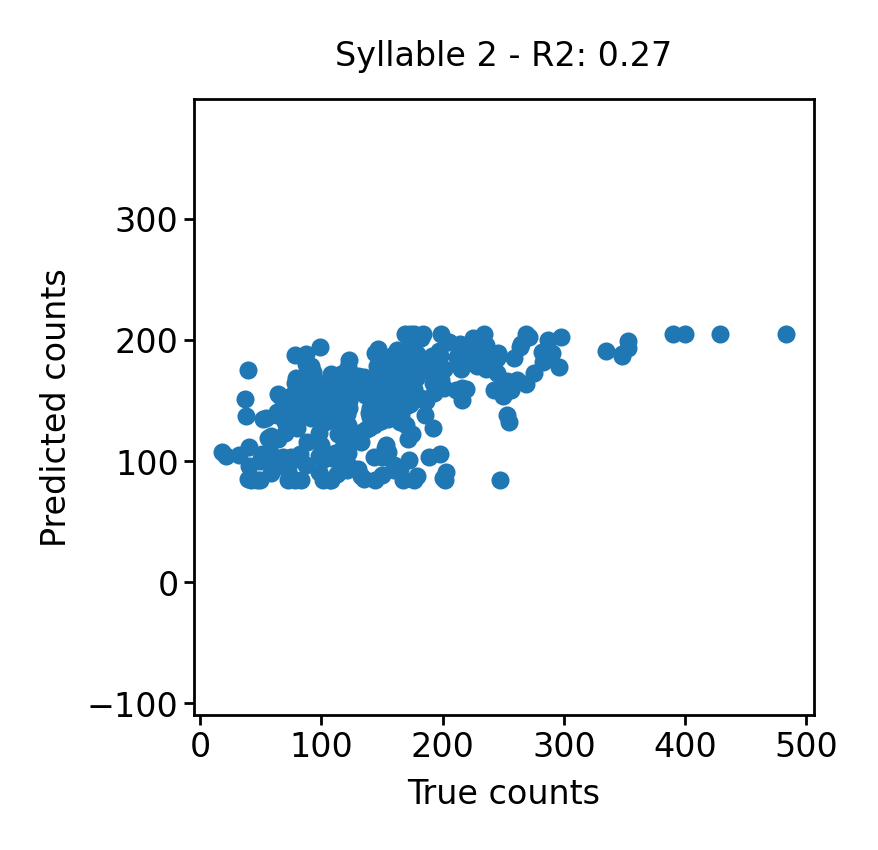

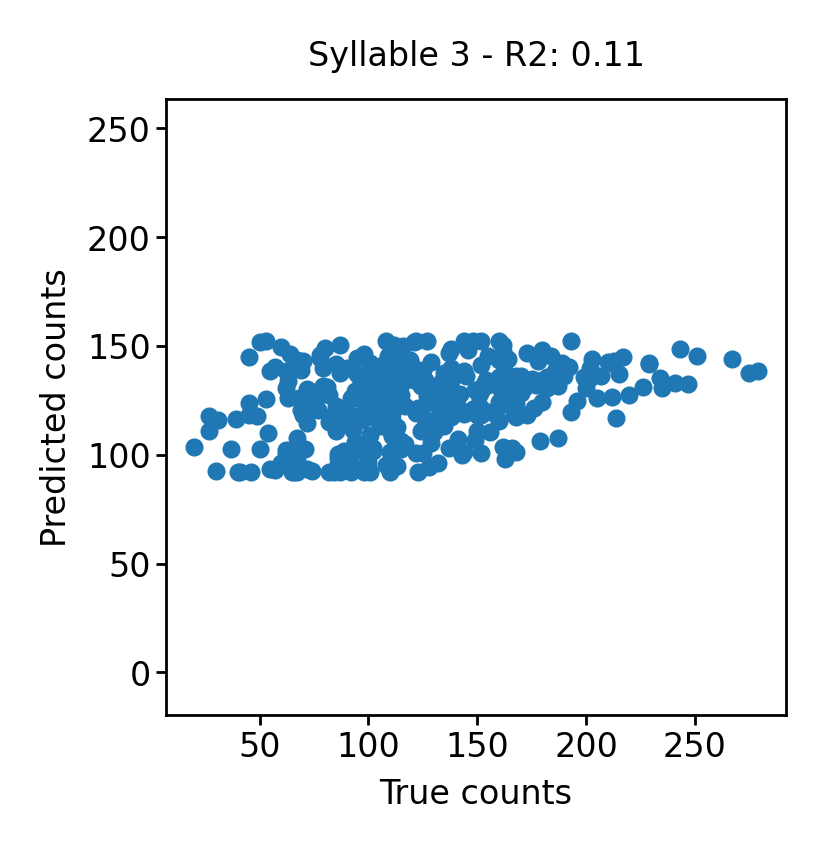

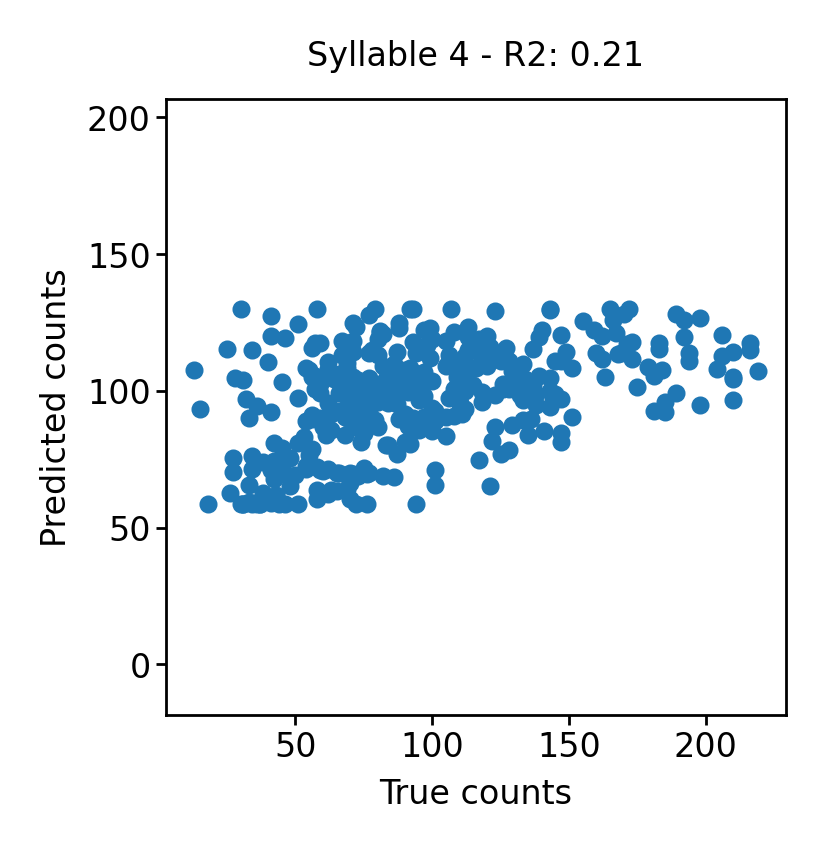

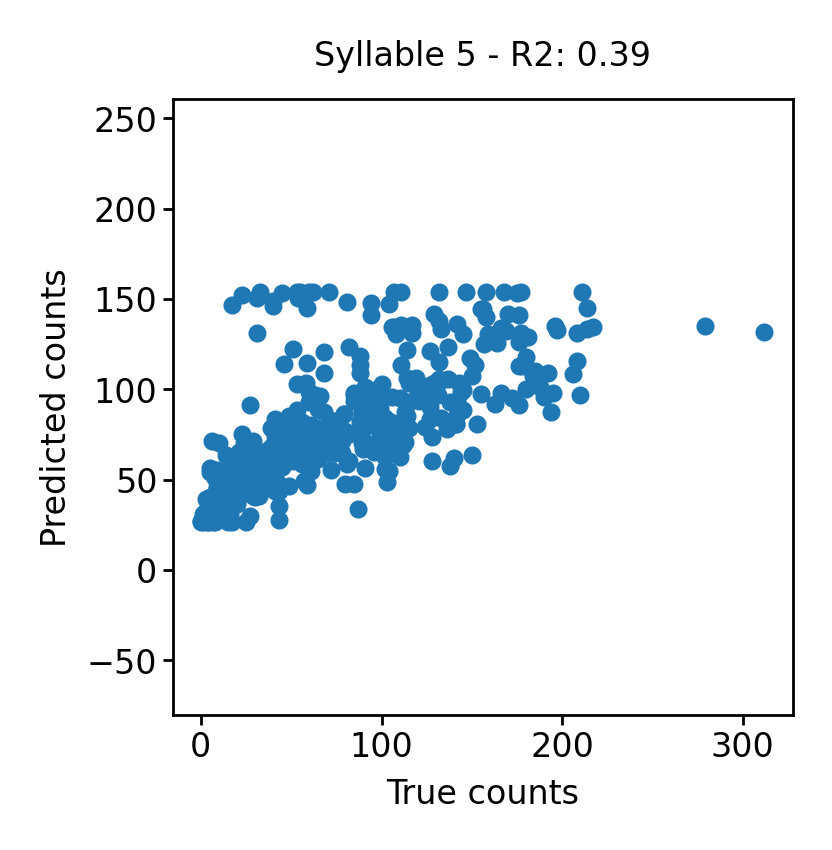

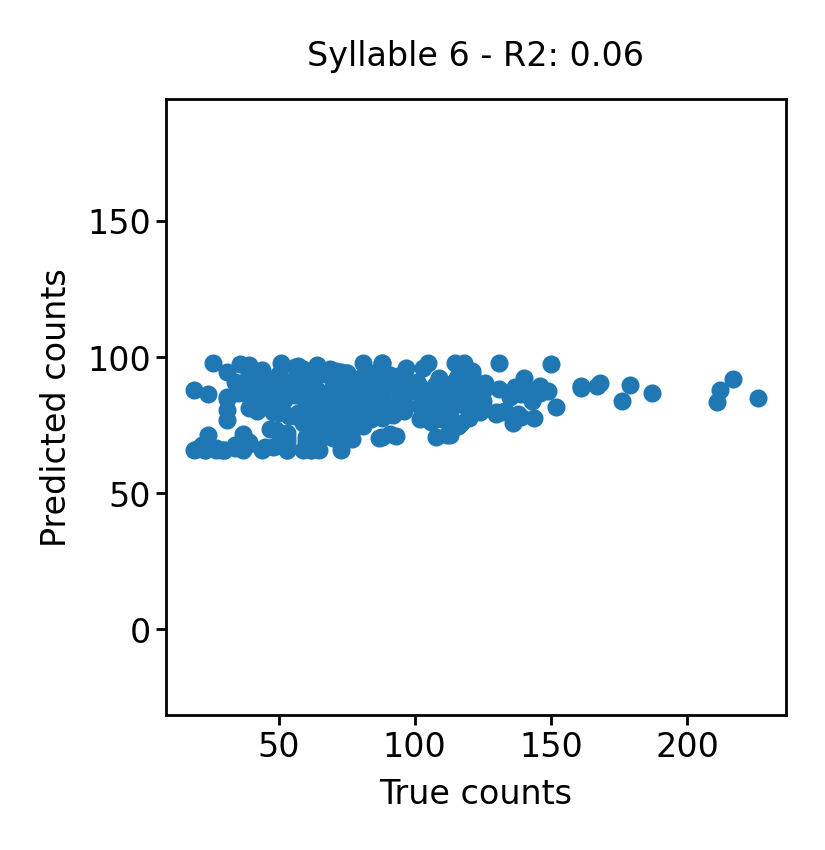

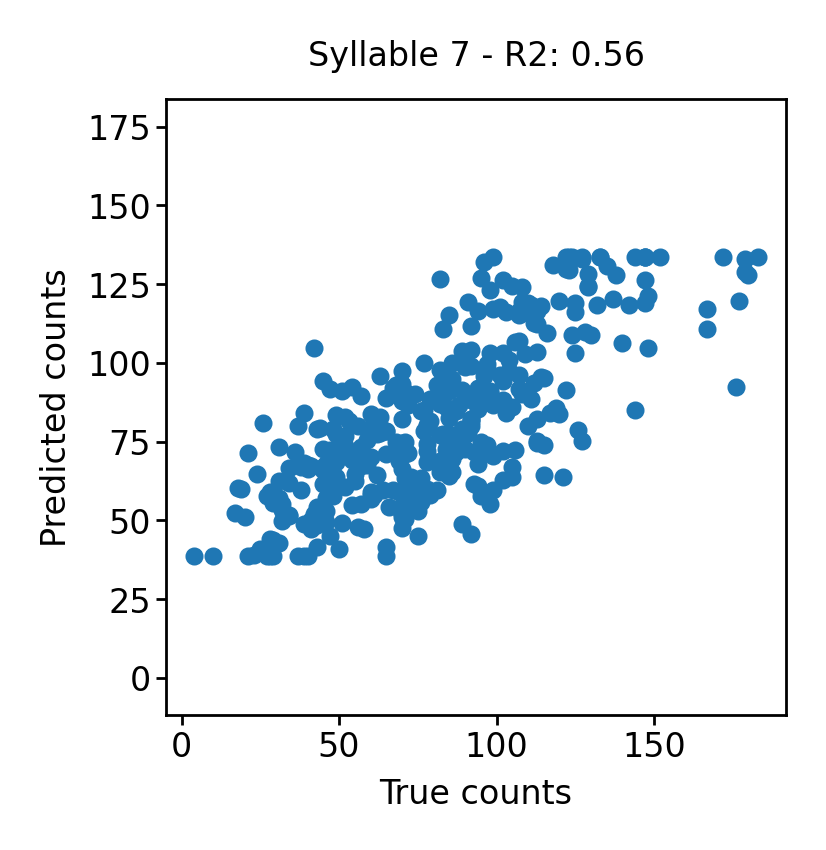

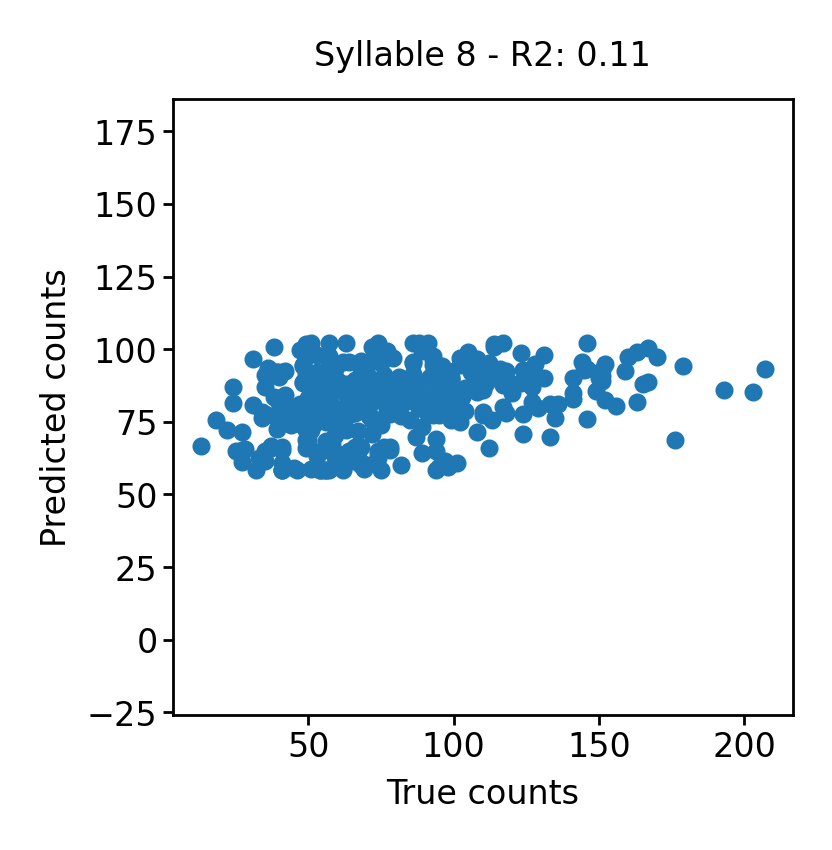

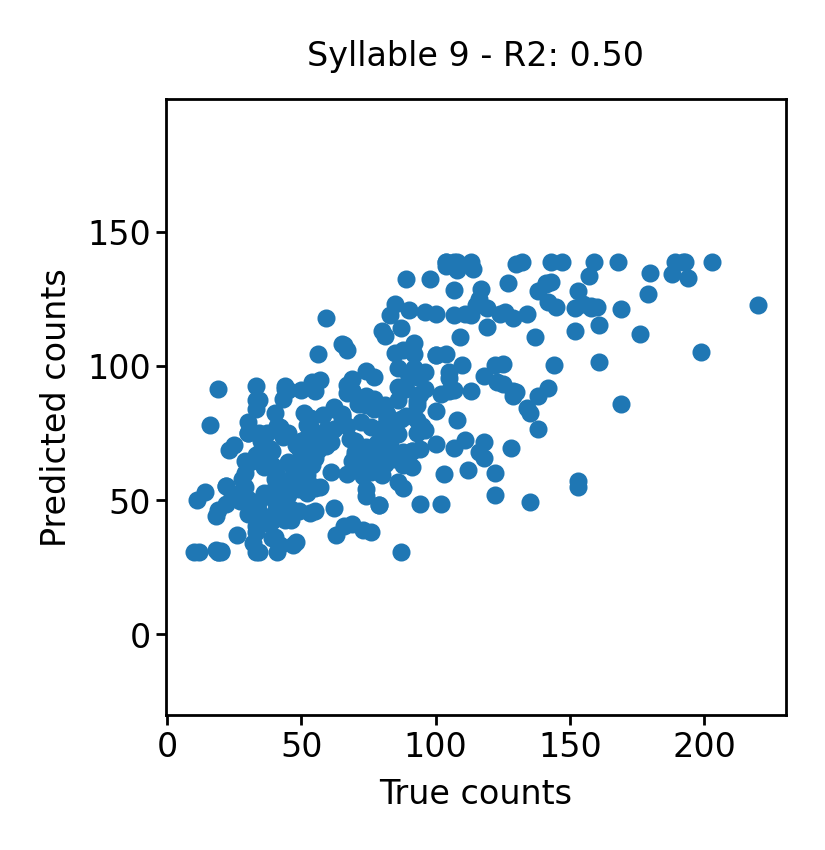

In [14]:
for syllable in range(10):
    plt.figure(figsize=(2, 2))
    _r2 = r2_score(syllable_counts_jax[:, syllable], out[:, syllable])
    plt.scatter(syllable_counts_jax[:, syllable], out[:, syllable], s=6)
    plt.title(f"Syllable {syllable} - R2: {_r2:0.2f}")
    plt.xlabel("True counts")
    plt.ylabel("Predicted counts")
    plt.axis('equal')

In [15]:
total_r2 = r2_score(syllable_counts_jax + 1, out, multioutput="variance_weighted")
total_r2

0.3470564085320183

In [112]:
# total_r2 = r2_score(syllable_counts_jax + 1, out)
# total_r2